# Random Forest Analysis

**Summary of Project**  
The goal of this project was to develop a highly accurate predictive model for loan approval decisions using machine learning techniques, with a focus on Random Forest. The model leverages feature engineering, hyperparameter tuning, and feature selection to optimize performance. The results show that Random Forest outperforms the baseline Logistic Regression model across all evaluation metrics, achieving an impressive accuracy of 99.18%.

## Load and Prepare Data

In [133]:
# Import libraries

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model and evaluation tools
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier          # Random Forest model
from sklearn.linear_model import LogisticRegression          # Baseline comparison
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  # Data splitting and tuning
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,roc_curve   # Evaluation metrics

In [205]:
# Load dataset
df = pd.read_csv("loan_approval_dataset.csv")
df.columns = df.columns.str.replace(' ', '') # Clean columns
df = df.drop(columns=["loan_id"]) # Drop unnecessary columns

#### Create new feature total_asset_value

In [138]:
# Add asset columns
df['total_asset_value'] = df['residential_assets_value'] + df['commercial_assets_value'] + df['luxury_assets_value'] + df['bank_asset_value']
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,total_asset_value
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved,50700000
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected,17000000
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected,57700000
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected,52700000
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected,55000000


#### Create numeric dataframe and split data for training and testing

In [141]:
# Create numeric dataframe
df = pd.get_dummies(df, dtype=int)
df = df.drop(columns=['loan_status_ Rejected', 'education_ Not Graduate', 'self_employed_ No'])

In [143]:
X = df.drop('loan_status_ Approved',axis=1)
y = df['loan_status_ Approved']

In [145]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [151]:
# Looking at data shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3415, 12)
(854, 12)
(3415,)
(854,)


In [149]:
# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## Logistic Regression Baseline Model

The baseline model serves as a reference for evaluating the performance of more complex models. Logistic Regression was chosen due to its simplicity and interpretability, making it an ideal starting point for comparison. To ensure the features were on a comparable scale, StandardScaler was first applied to normalize the data. The results show the model achieved an accuracy of 92.04%, an F1 score of 0.9352, and an AUC of 0.9712. The cross-validation scores indicate consistent performance, with the model achieving an average accuracy of 91.42% and AUC of 0.9670, suggesting that it generalizes well across different subsets of the data.

Classification Report:
              precision    recall  f1-score   support

           0     0.8806    0.9133    0.8967       323
           1     0.9461    0.9247    0.9352       531

    accuracy                         0.9204       854
   macro avg     0.9133    0.9190    0.9159       854
weighted avg     0.9213    0.9204    0.9206       854



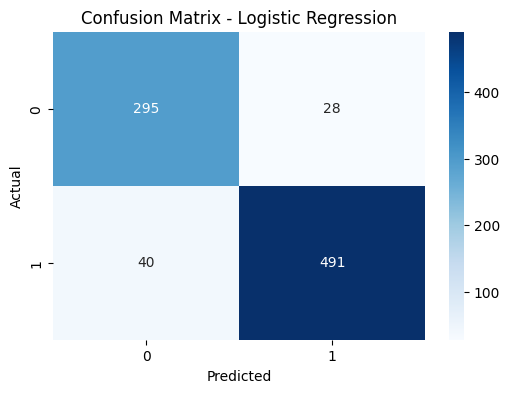

ROC AUC Score: 0.9712


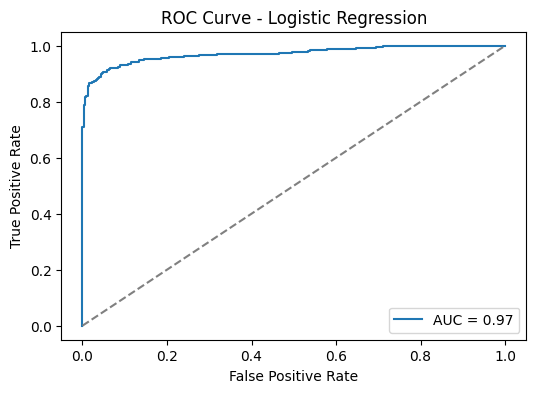

Cross-Validated Scores (5-fold):
Acc: 0.9142 (+/- 0.00)
AUC: 0.9670 (+/- 0.01)


In [165]:
# Standardize features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit logistic regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_preds = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ROC AUC Score
auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

# Cross-Validation
cv_scores_acc = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='accuracy')
cv_scores_auc = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='roc_auc')

print("Cross-Validated Scores (5-fold):")
print(f"Acc: {cv_scores_acc.mean():.4f} (+/- {cv_scores_acc.std():.2f})")
print(f"AUC: {cv_scores_auc.mean():.4f} (+/- {cv_scores_auc.std():.2f})")

## Random Forest Model

#### Base model

The Random Forest model, using the default hyperparameters, demonstrated strong performance, achieving an accuracy of 98.48%, an F1 score of 0.9877, and an AUC of 0.9995 on the test set. These results significantly outperform the Logistic Regression baseline, which achieved an accuracy of 92% and an AUC of 0.9712. Additionally, the model's cross-validation scores show consistent performance, with an average accuracy of 97.66% and AUC of 0.9957.

Classification Report:
              precision    recall  f1-score   support

           0     0.9784    0.9814    0.9799       323
           1     0.9887    0.9868    0.9877       531

    accuracy                         0.9848       854
   macro avg     0.9835    0.9841    0.9838       854
weighted avg     0.9848    0.9848    0.9848       854



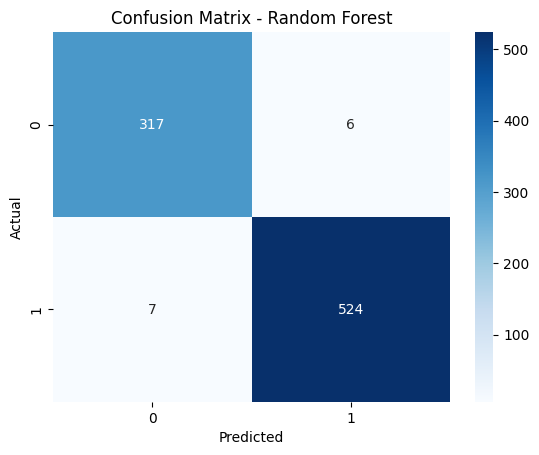

ROC AUC Score: 0.9995
Cross-Validation Scores (5-fold):
Acc: 0.9766 (+/- 0.01)
AUC: 0.9957 (+/- 0.00)


In [167]:
# Fit model
rf = RandomForestClassifier(random_state=42)   
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ROC AUC Score
auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {auc:.4f}")

# Cross-Validation Scores
cv_scores_acc = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_auc = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')

print("Cross-Validation Scores (5-fold):")
print(f"Acc: {cv_scores_acc.mean():.4f} (+/- {cv_scores_acc.std():.2f})")
print(f"AUC: {cv_scores_auc.mean():.4f} (+/- {cv_scores_auc.std():.2f})")

#### Feature importance

The most influential feature in predicting loan approval is Cibil Score (credit score), which stands out as the most important predictor in the model. To enhance model simplicity and efficiency, redundant and less important features were systematically removed. This feature selection process contributed to an improvement in model performance, resulting in higher accuracy and more stable predictions.

In [171]:
feature_importance = rf.feature_importances_

# Create a DataFrame with feature and their corresponding importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
4,cibil_score,0.804432
3,loan_term,0.059204
2,loan_amount,0.027126
9,total_asset_value,0.017904
1,income_annum,0.016672
7,luxury_assets_value,0.016375
6,commercial_assets_value,0.015694
5,residential_assets_value,0.015525
8,bank_asset_value,0.014555
0,no_of_dependents,0.007798


In [173]:
# Drop less important and redundant features
X = df.drop(['loan_status_ Approved', 'luxury_assets_value', 'commercial_assets_value', 'residential_assets_value', 
             'bank_asset_value', 'no_of_dependents', 'self_employed_ Yes', 'education_ Graduate'],axis=1)
y = df['loan_status_ Approved']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

#### Check model performance

In [175]:
# Fit model
rf = RandomForestClassifier(random_state=42)   
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ROC AUC Score
auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {auc:.4f}")

# Cross-Validation Scores
cv_scores_acc = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_auc = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')

print("Cross-Validation Scores (5-fold):")
print(f"Acc: {cv_scores_acc.mean():.4f} (+/- {cv_scores_acc.std():.2f})")
print(f"AUC: {cv_scores_auc.mean():.4f} (+/- {cv_scores_auc.std():.2f})")

Classification Report:
              precision    recall  f1-score   support

           0     0.9908    0.9969    0.9938       323
           1     0.9981    0.9944    0.9962       531

    accuracy                         0.9953       854
   macro avg     0.9944    0.9956    0.9950       854
weighted avg     0.9953    0.9953    0.9953       854

ROC AUC Score: 0.9999
Cross-Validation Scores (5-fold):
Acc: 0.9810 (+/- 0.00)
AUC: 0.9966 (+/- 0.00)


#### Explore number of trees

The effect of varying the number of trees (n_estimators) in the Random Forest model was evaluated. The model's accuracy was measured across three metrics: training accuracy, cross-validation accuracy, and out-of-bag (OOB) accuracy. As the number of trees increased, both cross-validation accuracy and OOB accuracy improved up to 100 trees, after which they stabilized and showed minimal further improvement. These results suggest that increasing the number of trees beyond 100 offers diminishing returns in terms of model performance. Therefore, 100 trees strikes a good balance between model complexity and predictive performance.

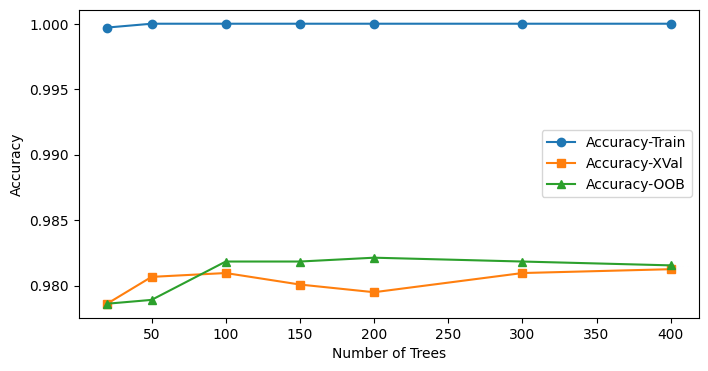

In [178]:
values = [20, 50, 100, 150, 200, 300, 400]
t_acc = np.array([])
cv_acc = np.array([])
oob_acc = np.array([])

for n in values:
    rf = RandomForestClassifier(n_estimators=n, random_state=42, oob_score=True)   
    rf.fit(X_train, y_train)

    #accuracy score for training set
    ACC_train = rf.score(X_train, y_train) 
    
    #cross-validation score
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
    ACC_cross_val = scores.mean()

    #out-of-bag score
    ACC_oob = rf.oob_score_

    #append scores
    t_acc = np.append(t_acc, [ACC_train])
    cv_acc = np.append(cv_acc, [ACC_cross_val])
    oob_acc = np.append(oob_acc, [ACC_oob])

fig, ax = plt.subplots(figsize=(8, 4))  
ax.plot(values, t_acc, label='Accuracy-Train', marker='o')
ax.plot(values, cv_acc, label='Accuracy-XVal', marker='s')
ax.plot(values, oob_acc, label='Accuracy-OOB', marker='^')
ax.set_ylabel('Accuracy')  
ax.set_xlabel('Number of Trees')  
ax.legend()  
plt.show()

#### Perform Grid Search to tune hyperparameters

In [181]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],   # Number of trees in the forest
    'max_depth': [None, 10, 20],      # Maximum depth of the tree
    'min_samples_split': [2, 5],      # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required at each leaf node
    'max_features': ['sqrt', 3],      # The number of features to consider when looking for the best split
}

# Set up GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters from grid search
print(f"Best parameters found: {grid_search.best_params_}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


#### Evaluate final model using best parameters

              precision    recall  f1-score   support

           0     0.9907    0.9876    0.9891       323
           1     0.9925    0.9944    0.9934       531

    accuracy                         0.9918       854
   macro avg     0.9916    0.9910    0.9913       854
weighted avg     0.9918    0.9918    0.9918       854



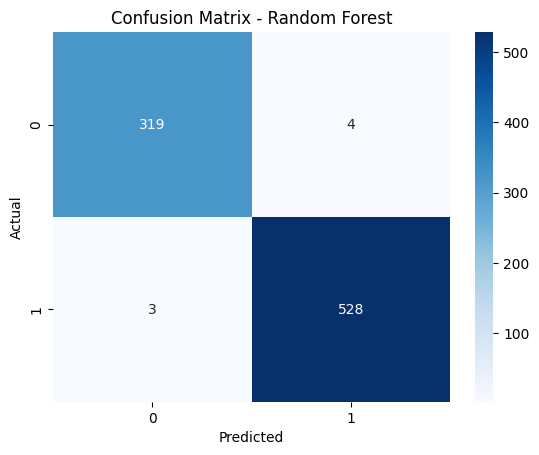

ROC AUC Score: 0.9998


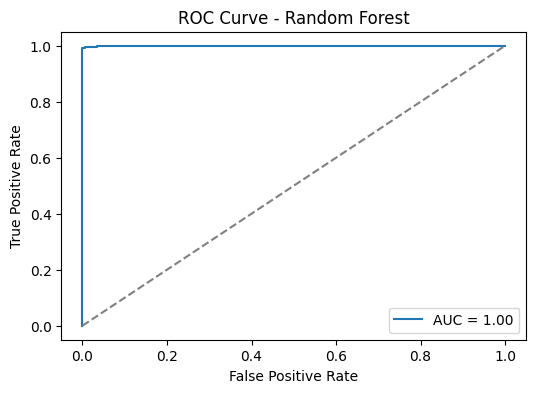

Cross-Validation Scores (5-fold):
Acc: 0.9818 (+/- 0.00)
AUC: 0.9973 (+/- 0.00)


In [185]:
# Make predictions with the best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ROC AUC Score
y_proba = best_rf.predict_proba(X_test)[:, 1]  # Get the probability of the positive class
auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

# Cross-Validation Scores
cv_scores_acc = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_auc = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='roc_auc')

print("Cross-Validation Scores (5-fold):")
print(f"Acc: {cv_scores_acc.mean():.4f} (+/- {cv_scores_acc.std():.2f})")
print(f"AUC: {cv_scores_auc.mean():.4f} (+/- {cv_scores_auc.std():.2f})")

#### Logistic Regression vs Random Forest

In [197]:
# Create dataframe
score_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Logistic Regression': [0.9204, 0.9461, 0.9247, 0.9352, 0.9712],
    'Random Forest': [0.9918, 0.9925, 0.9944, 0.9934, 0.9998]
}

score_df = pd.DataFrame(score_data)
score_df

,Metric,Logistic Regression,Random Forest
0,Accuracy,0.9204,0.9918
1,Precision,0.9461,0.9925
2,Recall,0.9247,0.9944
3,F1 Score,0.9352,0.9934
4,AUC,0.9712,0.9998


### Summary of Results
The Random Forest model demonstrated a significant improvement over Logistic Regression, achieving higher scores across all metrics, including accuracy (99.18%), precision (99.25%), and AUC (0.9998). The final model misclassified only 7 samples from the testing data,  demonstrating its high accuracy and reliability. The cross-validation results (98.18% average accuracy and 0.9973 average AUC score) reinforce the model's ability to generalize effectively to unseen data. Overall, Random Forest proves to be a robust and highly precise model, offering excellent predictive performance.